In [26]:
import glob
import os
import imageio
import numba
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

## Figure S9a

In [3]:
datadir = '/data/users/julie/Data/Spots_barcode_Emily/dataset_2/output_expr_comparison/'
rb_2rc_files = sorted(glob.glob(datadir + 'rel*2*R*C/*trunc.csv'))
df = pd.read_csv(rb_2rc_files[0])
df_dict_2rc = dict(df.predicted_name.value_counts())
for key in df_dict_2rc:
    df_dict_2rc[key] = np.log10(df_dict_2rc[key]+1)

In [4]:
fpkmdir = '/data/users/emily/moffit_lab/bulk_FPKM.csv'
df_fpkm = pd.read_csv(fpkmdir)
dict_fpkm = {}
for i in range(len(df_fpkm)):
    if df_fpkm.FPKM[i] == 0:
        continue
    dict_fpkm[df_fpkm.geneName[i]] = np.log10(df_fpkm.FPKM[i])

In [6]:
z=4

for fov in tqdm(df.fov_id.unique()):
    df_fov = df.loc[df.fov_id == fov]
    df_fov = df_fov.loc[df_fov.probability > 0.5]
#     df_fov = df_fov.loc[df_fov.z == z]
    df_fov = df_fov.reset_index(drop=True)
    
    pred = imageio.volread('/data/users/emily/moffit_lab/mesmer_predictions/fov_{}.tif'.format(int(fov)))
    
    cell_list = []
    for ii in range(len(df_fov)):
        cell_list.append(pred[z, int(df_fov.x.iloc[ii]), int(df_fov.y.iloc[ii]), 0])
    df_fov['cell'] = cell_list
    
    if fov == 201:
        df_cell_counts = pd.DataFrame(columns=['Cell', 'FOV']+list(df_fov.predicted_name.unique()))
    
    for cell in df_fov.cell.unique():
        if cell == 0:
            continue
        df_cell = df_fov.loc[df_fov.cell == cell]
        cell_counts = dict(df_cell.predicted_name.value_counts())
        for key in cell_counts:
            cell_counts[key] = [cell_counts[key]]
        if len(cell_counts.keys()) == 0:
            continue
        cell_counts['Cell'] = cell
        cell_counts['FOV'] = fov
        df_cell_counts = pd.concat((df_cell_counts, pd.DataFrame.from_dict(cell_counts, orient='columns')), axis=0)
        
df_cell_counts = df_cell_counts.fillna(0)
df_cell_counts = df_cell_counts.reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [05:24<00:00, 12.50s/it]


In [7]:
for col in df_cell_counts:
    if type(col)==float:
        df_cell_counts = df_cell_counts.drop(col, axis=1)
    elif 'background' in col:
        df_cell_counts = df_cell_counts.drop(col, axis=1)
#     elif 'Blank' in col:
#         df_cell_counts = df_cell_counts.drop(col, axis=1)
    df_cell_counts = df_cell_counts[df_cell_counts.Cell != 0]

df_cell_counts

,Cell,FOV,Acta2,Kit,Fzd3,Sdc1,Nlrp6,Ffar3,Ifnar1,Lrmp,...,Mboat4,Crp,Drd2,Blank-21,Blank-18,Blank-04,Taar7b,Blank-05,Ccr3,Blank-17
0,23,201,34,16,0,1,0,7,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,201,26,0,2,0,0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,201,73,1,0,4,0,4,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,201,166,1,0,3,2,20,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29,201,0,1,0,0,3,3,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5605,8,229,0,2,0,2,3,0,3,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5606,38,229,1,0,0,3,3,0,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5607,44,229,0,0,0,1,4,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5608,31,229,0,0,0,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dict_percell_2rc = {}
for col in df_cell_counts.columns:
    dict_percell_2rc[col] = np.log10(np.mean(df_cell_counts[col]))

In [33]:
datadir = '/data/users/julie/Data/Spots_barcode_Emily/dataset_2/output_expr_comparison/'
post_files = sorted(glob.glob(datadir + 'original*code/*trunc.csv'))
df = pd.read_csv(post_files[0])
df_dict_post = dict(df.predicted_name.value_counts())
for key in df_dict_post:
    df_dict_post[key] = np.log10(df_dict_post[key]+1)

In [34]:
z=4

for fov in tqdm(df.fov_id.unique()):
    df_fov = df.loc[df.fov_id == fov]
    df_fov = df_fov.loc[df_fov.probability > 0.5]
#     df_fov = df_fov.loc[df_fov.z == z]
    df_fov = df_fov.reset_index(drop=True)
    
    pred = imageio.volread('/data/users/emily/moffit_lab/mesmer_predictions/fov_{}.tif'.format(int(fov)))
    
    cell_list = []
    for ii in range(len(df_fov)):
        cell_list.append(pred[z, int(df_fov.x.iloc[ii]), int(df_fov.y.iloc[ii]), 0])
    df_fov['cell'] = cell_list
    
    if fov == 201:
        df_cell_counts = pd.DataFrame(columns=['Cell', 'FOV']+list(df_fov.predicted_name.unique()))
    
    for cell in df_fov.cell.unique():
        if cell == 0:
            continue
        df_cell = df_fov.loc[df_fov.cell == cell]
        cell_counts = dict(df_cell.predicted_name.value_counts())
        for key in cell_counts:
            cell_counts[key] = [cell_counts[key]]
        if len(cell_counts.keys()) == 0:
            continue
        cell_counts['Cell'] = cell
        cell_counts['FOV'] = fov
        df_cell_counts = pd.concat((df_cell_counts, pd.DataFrame.from_dict(cell_counts, orient='columns')), axis=0)
        
df_cell_counts = df_cell_counts.fillna(0)
df_cell_counts = df_cell_counts.reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [03:10<00:00,  7.32s/it]


In [35]:
for col in df_cell_counts:
    if type(col)==float:
        df_cell_counts = df_cell_counts.drop(col, axis=1)
    elif 'background' in col:
        df_cell_counts = df_cell_counts.drop(col, axis=1)
#     elif 'Blank' in col:
#         df_cell_counts = df_cell_counts.drop(col, axis=1)
    df_cell_counts = df_cell_counts[df_cell_counts.Cell != 0]

df_cell_counts

,Cell,FOV,Cd79b,Vim,Maoa,Smo,Acta2,Ptger3,Tspan13,Fzd2,...,Sell,Blank-10,Taar9,Crp,Blank-16,Blank-24,Taar7b,Taar8b,Il4,Blank-15
0,3,201,0,0,0,0,10,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,201,0,4,3,1,125,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,201,0,0,0,0,86,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,201,0,1,0,0,197,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,201,0,0,0,0,28,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5184,25,229,0,0,6,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5185,30,229,0,0,2,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5186,8,229,0,1,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5187,31,229,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
dict_percell_post = {}
for col in df_cell_counts.columns:
    dict_percell_post[col] = np.log10(np.mean(df_cell_counts[col]))

In [63]:
moff_files = sorted(glob.glob('/data/users/julie/Data/*Emily*/*2/*.csv'))
moff_files

['/data/users/julie/Data/Spots_barcode_Emily/dataset_2/barcodes.csv',
 '/data/users/julie/Data/Spots_barcode_Emily/dataset_2/decoded_spots_updated.csv',
 '/data/users/julie/Data/Spots_barcode_Emily/dataset_2/tile_positions.csv']

In [64]:
df = pd.read_csv(moff_files[1])
codebook = pd.read_csv(moff_files[0])

pred_name = []
for i in tqdm(range(len(df))):
    idx = df.barcode_id[i] - 1
    pred_name.append(codebook['Unnamed: 0'][idx])
    
df['predicted_name'] = pred_name
df_dict_moff = dict(df.predicted_name.value_counts())
for key in df_dict_moff:
    df_dict_moff[key] = np.log10(df_dict_moff[key]+1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1155581/1155581 [00:31<00:00, 36792.25it/s]


In [65]:
z=4

for fov in tqdm(df.fov_id.unique()):
    df_fov = df.loc[df.fov_id == fov]
#     df_fov = df_fov.loc[df_fov.probability > 0.5]
#     df_fov = df_fov.loc[df_fov.z == z]
    df_fov = df_fov.reset_index(drop=True)
    
    pred = imageio.volread('/data/users/emily/moffit_lab/mesmer_predictions/fov_{}.tif'.format(int(fov)))
    
    cell_list = []
    for ii in range(len(df_fov)):
        cell_list.append(pred[z, int(df_fov.x.iloc[ii]), int(df_fov.y.iloc[ii]), 0])
    df_fov['cell'] = cell_list
    
    if fov == 201:
        df_cell_counts = pd.DataFrame(columns=['Cell', 'FOV']+list(df_fov.predicted_name.unique()))
    
    for cell in df_fov.cell.unique():
        if cell == 0:
            continue
        df_cell = df_fov.loc[df_fov.cell == cell]
        cell_counts = dict(df_cell.predicted_name.value_counts())
        for key in cell_counts:
            cell_counts[key] = [cell_counts[key]]
        if len(cell_counts.keys()) == 0:
            continue
        cell_counts['Cell'] = cell
        cell_counts['FOV'] = fov
        df_cell_counts = pd.concat((df_cell_counts, pd.DataFrame.from_dict(cell_counts, orient='columns')), axis=0)
        
df_cell_counts = df_cell_counts.fillna(0)
df_cell_counts = df_cell_counts.reset_index(drop=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:13<00:00,  6.23s/it]


In [66]:
for col in df_cell_counts:
    if type(col)==float:
        df_cell_counts = df_cell_counts.drop(col, axis=1)
    elif 'Blank' in col or 'background' in col:
        df_cell_counts = df_cell_counts.drop(col, axis=1)
    df_cell_counts = df_cell_counts[df_cell_counts.Cell != 0]

df_cell_counts

,Cell,FOV,Slc51a,Maoa,Hmgb2,Cps1,Txndc5,Klk1,Clca3b,Mptx2,...,Cxcr5,Ifng,Adra2c,Chrm5,Neurog3,Gpr174,Drd4,Taar7f,Adra1b,Il9
0,21,201,1,3,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23,201,0,4,0,0,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17,201,0,1,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,201,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,201,0,3,1,0,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,13,230,19,1,0,0,10,9,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4557,4,230,1,1,0,0,10,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4558,15,230,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4559,14,230,0,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
dict_percell_moff = {}
for col in df_cell_counts.columns:
    dict_percell_moff[col] = np.log10(np.mean(df_cell_counts[col]))

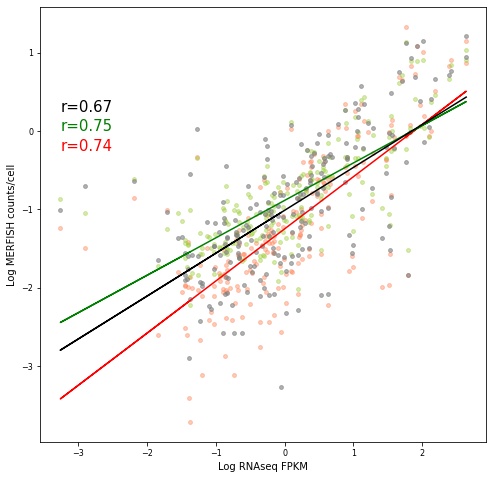

In [98]:
x=[]
y=[]
for key in df_dict_post:
    if key == 'Mptx2':
        continue
    if key in dict_fpkm:
        x.append(dict_fpkm[key])
        y.append(dict_percell_post[key])

slope, intercept, r, p, std_err = stats.linregress(x, y)

def func(x):
  return slope * x + intercept

fit = list(map(func, x))
plt.figure(figsize=(8,8))
plt.scatter(x, y, c='coral', alpha=0.4, s=15)
plt.plot(x, fit, c='r', label='PoSTcode')
# plt.annotate('y={}x+{}'.format(np.round(slope, 2),np.round(intercept,2)), (-3,1.5), fontsize=15)
plt.annotate('r={}'.format(np.round(r, 2)), (-3.25,-0.25), fontsize=15, color='r')

x=[]
y=[]
for key in df_dict_moff:
    if key == 'Mptx2':
        continue
    if key in dict_fpkm:
        x.append(dict_fpkm[key])
        y.append(dict_percell_moff[key])

slope, intercept, r, p, std_err = stats.linregress(x, y)


fit = list(map(func, x))
plt.scatter(x, y, c='yellowgreen', alpha=0.4, s=15)
plt.plot(x, fit, c='green', label='Petukhov, et al.')
# plt.annotate('y={}x+{}'.format(np.round(slope, 2),np.round(intercept,2)), (-3.5,1.5), fontsize=15)
plt.annotate('r={}'.format(np.round(r, 2)), (-3.25,0), fontsize=15, color='green')

x=[]
y=[]
for key in df_dict_2rc:
    if key == 'Mptx2':
        continue
    if key in dict_fpkm:
        x.append(dict_fpkm[key])
        y.append(dict_percell_2rc[key])

slope, intercept, r, p, std_err = stats.linregress(x, y)


fit = list(map(func, x))
plt.scatter(x, y, c='grey', alpha=0.6, s=15)
plt.plot(x, fit, c='k', label='Polaris')
# plt.annotate('y={}x+{}'.format(np.round(slope, 2),np.round(intercept,2)), (-3.5,1.5), fontsize=15)
plt.annotate('r={}'.format(np.round(r, 2)), (-3.25,0.25), fontsize=15, color='k')

plt.xlabel('Log RNAseq FPKM')
plt.ylabel('Log MERFISH counts/cell')
# plt.xlim([-4,4])
# plt.ylim([-4,1.6])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal'}

matplotlib.rc('font', **font)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.savefig('/data/users/emily/publication_figures/supp_fig9a.pdf')

## Figure S9b

In [55]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]


@numba.jit(nopython=True)
def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient.
    """
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.std(x) / np.std(y) \
                / np.sqrt(len(x)) / np.sqrt(len(y))

@numba.jit(nopython=True)
def draw_bs_pairs_reps_pearson(x, y, size=1):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = pearson_r(*draw_bs_pairs(x, y))
    return out

In [56]:
x=[]
y=[]
for key in df_dict_post:
    if key == 'Mptx2':
        continue
    if key in dict_fpkm:
        x.append(dict_fpkm[key])
        y.append(df_dict_post[key])
        
x = np.array(x)
y = np.array(y)

bs_reps_post = draw_bs_pairs_reps_pearson(x, 
                                          y,
                                          size=10000)

In [57]:
x=[]
y=[]
for key in df_dict_2rc:
    if key == 'Mptx2':
        continue
    if key in dict_fpkm:
        x.append(dict_fpkm[key])
        y.append(df_dict_2rc[key])

x = np.array(x)
y = np.array(y)
        
bs_reps_2rc = draw_bs_pairs_reps_pearson(x, 
                                         y,
                                         size=10000)

In [86]:
x=[]
y=[]
for key in df_dict_moff:
    if key == 'Mptx2':
        continue
    if key in dict_fpkm:
        x.append(dict_fpkm[key])
        y.append(df_dict_moff[key])

x = np.array(x)
y = np.array(y)
        
bs_reps_moff = draw_bs_pairs_reps_pearson(x, 
                                         y,
                                         size=10000)

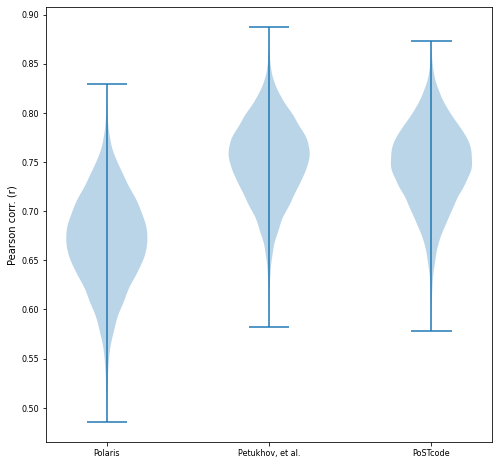

In [96]:
plt.figure(figsize=(8,8))
plt.violinplot([bs_reps_2rc, bs_reps_moff, bs_reps_post])
plt.xticks([1,2,3], ['Polaris', 'Petukhov, et al.', 'PoSTcode'])
plt.ylabel('Pearson corr. (r)')
# plt.savefig('/data/users/emily/publication_figures/supp_fig9b.pdf')